<a href="https://colab.research.google.com/github/zbiery/fin-services-case-study/blob/main/Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Financial Services Case Study**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [5]:
path = '_28For_Candidate_29_dspm_case_data_set_-__28For_Candidate_29_dspm_case_data_set.csv'
df = pd.read_csv(path)
df.head()

,userId,sessionReferrer,browser,deviceType,estimatedAnnualIncome,estimatedPropertyType,visitCount,pageURL,ctaCopy,ctaPlacement,editorialSnippet,scrolledPage,scrollDepth,clickedCTA,scheduledAppointment,revenue,mortgageVariation
0,user_97048,Google,Safari,Mobile,152000,Apartment,1,https://www.financialservices.com/mortgages/ty...,First Time? We've Made it Easy to Find the Bes...,Middle,"Understand the pros and cons of fixed-rate, ad...",1,75,0,0,0,NaN
1,user_14393,Social,Safari,Mobile,140000,Apartment,2,https://www.financialservices.com/mortgages/ho...,Access Your Personalized Mortgage Rates Now,Bottom,Equip yourself with knowledge. Understand the ...,1,25,0,0,0,NaN
2,user_30959,Direct,Safari,Mobile,128000,House,1,https://www.financialservices.com/mortgages/fi...,Access Your Personalized Mortgage Rates Now,Bottom,Navigate the home buying journey with confiden...,1,75,0,0,0,NaN
3,user_88588,Google,Chrome,Mobile,205000,Apartment,1,https://www.financialservices.com/mortgages/re...,Get Pre-Approved for a Mortgage in 5 Minutes,Middle,Our tools help you assess whether refinancing ...,1,75,1,0,0,NaN
4,user_65965,Google,Safari,Mobile,373000,House,1,https://www.financialservices.com/mortgages/re...,Access Your Personalized Mortgage Rates Now,Top,Navigate the complexities of mortgage rates wi...,0,0,0,0,0,NaN


In [6]:
df.isnull().any().sum()

1

In [7]:
df.describe()

,estimatedAnnualIncome,visitCount,scrolledPage,scrollDepth,clickedCTA,scheduledAppointment,revenue
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,130654.720000,2.225850,0.896760,62.258500,0.172610,0.055170,12.030350
std,62345.748304,2.070924,0.304274,30.139065,0.377912,0.228313,51.867358
min,50000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,90000.000000,1.000000,1.000000,50.000000,0.000000,0.000000,0.000000
50%,117000.000000,1.000000,1.000000,75.000000,0.000000,0.000000,0.000000
75%,145000.000000,3.000000,1.000000,75.000000,0.000000,0.000000,0.000000
max,400000.000000,10.000000,1.000000,100.000000,1.000000,1.000000,375.000000


In [8]:
df.drop_duplicates(inplace=True)

## **Part 1: Exploring Results from A/B Tests**

In [9]:
cta_performance = (df
                   .groupby(['ctaCopy', 'ctaPlacement'])
                   .agg({'revenue': 'mean','clickedCTA': 'mean'})
                   .reset_index()
                   .sort_values(by='revenue', ascending=False)
)
cta_performance

,ctaCopy,ctaPlacement,revenue,clickedCTA
3,First Time? We've Made it Easy to Find the Bes...,Bottom,12.905229,0.153092
8,Get Pre-Approved for a Mortgage in 5 Minutes,Top,12.680886,0.211753
5,First Time? We've Made it Easy to Find the Bes...,Top,12.286923,0.198452
2,Access Your Personalized Mortgage Rates Now,Top,12.120871,0.186482
4,First Time? We've Made it Easy to Find the Bes...,Middle,12.071371,0.169922
7,Get Pre-Approved for a Mortgage in 5 Minutes,Middle,11.753668,0.183332
6,Get Pre-Approved for a Mortgage in 5 Minutes,Bottom,11.697417,0.154172
1,Access Your Personalized Mortgage Rates Now,Middle,11.424264,0.161462
0,Access Your Personalized Mortgage Rates Now,Bottom,11.332463,0.134821


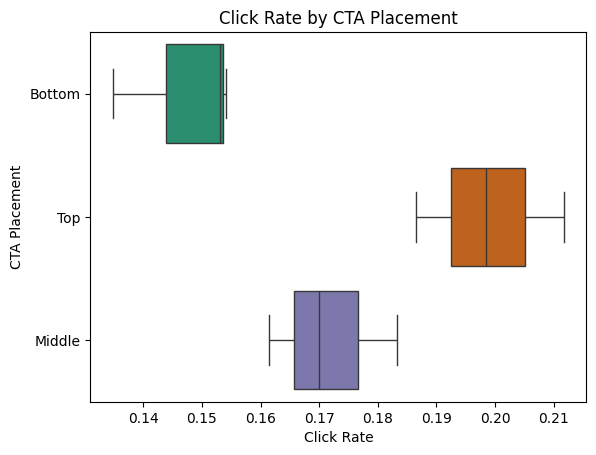

In [10]:
sns.boxplot(data=cta_performance, x='clickedCTA', y='ctaPlacement', palette='Dark2')
plt.title('Click Rate by CTA Placement')
plt.xlabel('Click Rate')
plt.ylabel('CTA Placement')
plt.show();

According to the mean revenue generated, CTA Version 2 with Placement Bottom performed the best, though it did not have the highest click rate. The CTA with the highest average click rate was Version 1 Placement Top.

If we sort the click rate descending, we can see that on average, CTAs with placements at the top of the webpage performed the best.

Looking purely at averages will not tell the whole story though.

In [11]:
cta_metrics = (df
               .groupby(['ctaCopy', 'ctaPlacement'])
               .agg(clicks=('clickedCTA', 'sum'),
                    impressions=('clickedCTA', 'count'),
                    appointments=('scheduledAppointment', 'sum'),
                    totalRevenue=('revenue', 'sum'))
               .reset_index()
               )

cta_metrics['clickRate'] = (cta_metrics['clicks'] / cta_metrics['impressions'])
cta_metrics['conversionRate'] = (cta_metrics['appointments'] / cta_metrics['impressions'])

version_mapping = {
    'Get Pre-Approved for a Mortgage in 5 Minutes' : 'Version 1',
    'First Time? We\'ve Made it Easy to Find the Best Mortgage Rate' : 'Version 2',
    'Access Your Personalized Mortgage Rates Now':'Version 3'
}

cta_metrics['version'] = cta_metrics['ctaCopy'].map(version_mapping)

cta_metrics

,ctaCopy,ctaPlacement,clicks,impressions,appointments,totalRevenue,clickRate,conversionRate,version
0,Access Your Personalized Mortgage Rates Now,Bottom,1498,11111,575,125915,0.134821,0.051751,Version 3
1,Access Your Personalized Mortgage Rates Now,Middle,1794,11111,563,126935,0.161462,0.050671,Version 3
2,Access Your Personalized Mortgage Rates Now,Top,2072,11111,607,134675,0.186482,0.054631,Version 3
3,First Time? We've Made it Easy to Find the Bes...,Bottom,1701,11111,632,143390,0.153092,0.056881,Version 2
4,First Time? We've Made it Easy to Find the Bes...,Middle,1888,11111,591,134125,0.169922,0.053191,Version 2
5,First Time? We've Made it Easy to Find the Bes...,Top,2205,11111,606,136520,0.198452,0.054541,Version 2
6,Get Pre-Approved for a Mortgage in 5 Minutes,Bottom,1713,11111,630,129970,0.154172,0.056701,Version 1
7,Get Pre-Approved for a Mortgage in 5 Minutes,Middle,2037,11111,643,130595,0.183332,0.057871,Version 1
8,Get Pre-Approved for a Mortgage in 5 Minutes,Top,2353,11112,670,140910,0.211753,0.060295,Version 1


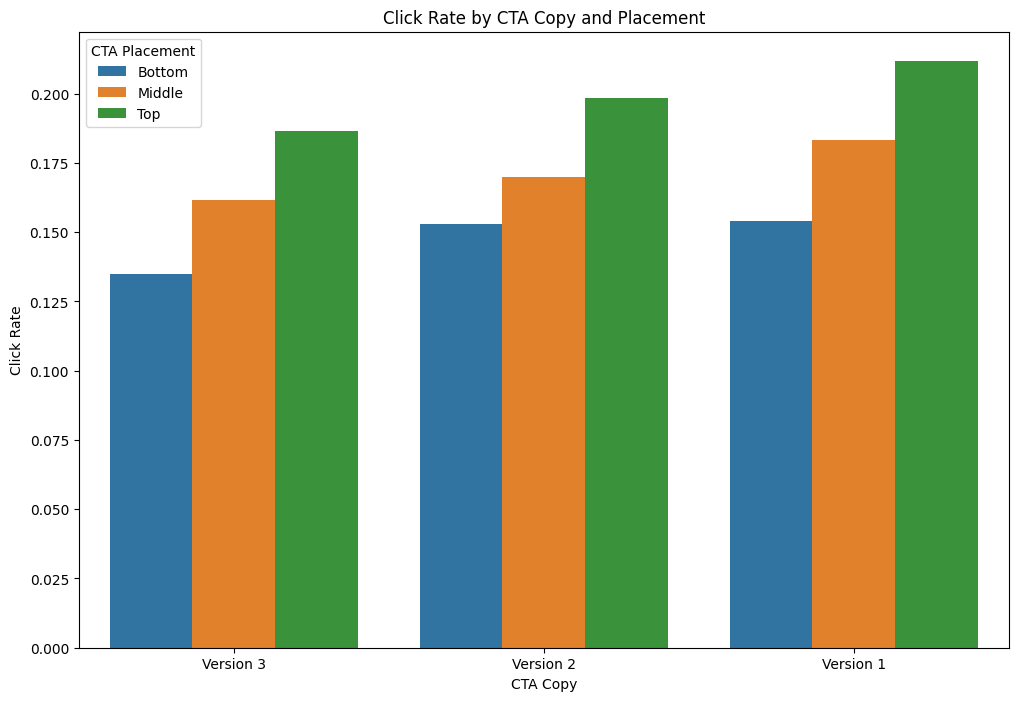

In [12]:
#Clicks
plt.figure(figsize=(12, 8))
sns.barplot(data=cta_metrics, x='version', y='clickRate', hue='ctaPlacement')
plt.title('Click Rate by CTA Copy and Placement')
plt.xlabel('CTA Copy')
plt.ylabel('Click Rate')
plt.legend(title='CTA Placement');

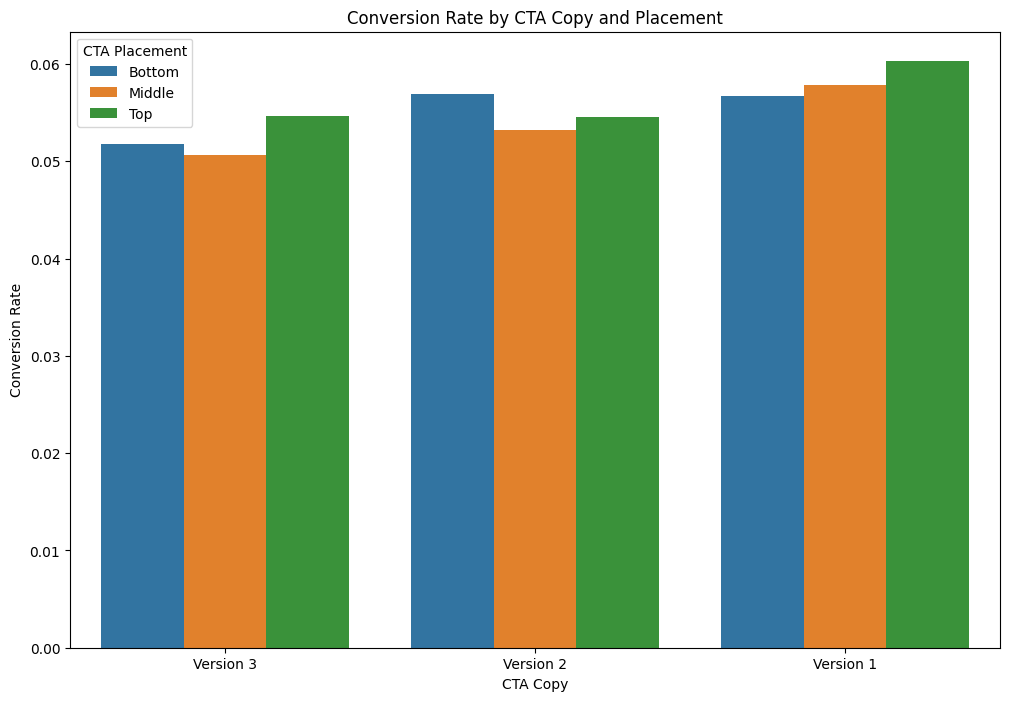

In [13]:
#Conversion
plt.figure(figsize=(12, 8))
sns.barplot(data=cta_metrics, x='version', y='conversionRate', hue='ctaPlacement')
plt.title('Conversion Rate by CTA Copy and Placement')
plt.xlabel('CTA Copy')
plt.ylabel('Conversion Rate')
plt.legend(title='CTA Placement');

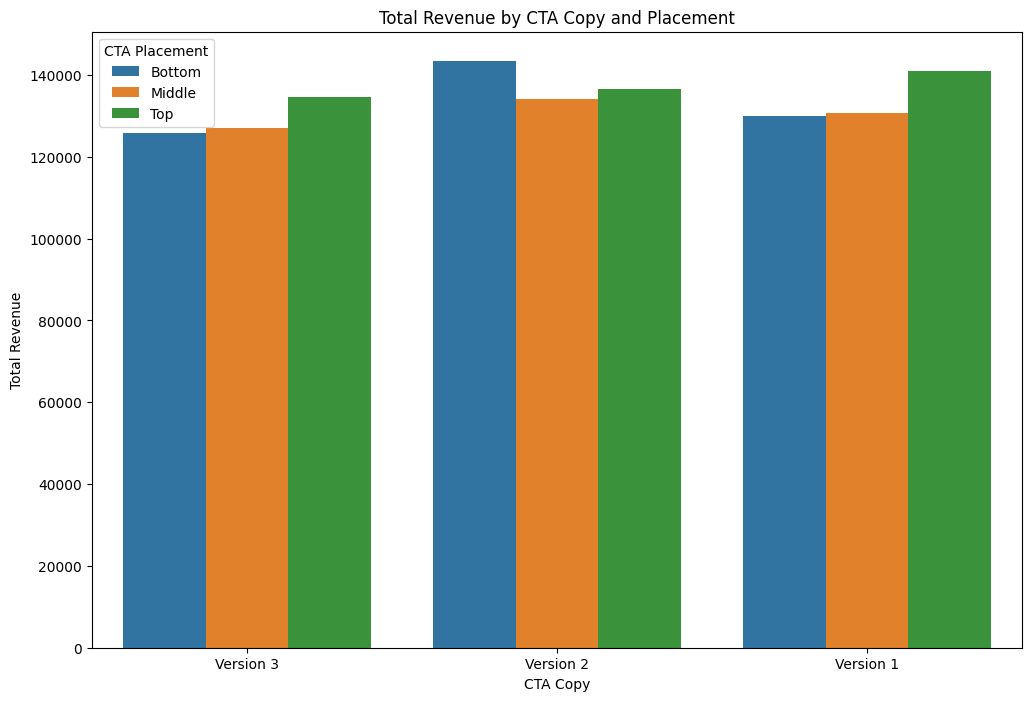

In [14]:
#Revenue
plt.figure(figsize=(12, 8))
sns.barplot(data=cta_metrics, x='version', y='totalRevenue', hue='ctaPlacement')
plt.title('Total Revenue by CTA Copy and Placement')
plt.xlabel('CTA Copy')
plt.ylabel('Total Revenue')
plt.legend(title='CTA Placement');

CTAs placed at the top consistently did the best across all key metrics. Version 1 ("Get Pre-Approved for a Mortgage in 5 Minutes") did the best in terms of click rate and conversion but was slightly beat out in revenue by version 2.


In [15]:
best_performer = cta_performance.iloc[0]
filter = (df['ctaPlacement'] != best_performer['ctaPlacement']) & (df['ctaCopy'] != best_performer['ctaCopy'])
avg_rev_rest = df[filter]['revenue'].mean()

incremental_value = best_performer['revenue'] - avg_rev_rest

print(
    f'''The incremental value of the champion is ${incremental_value:.2f}.
    This represents a {incremental_value / avg_rev_rest * 100:.2f}% increase in revenue.
    '''
    )

The incremental value of the champion is $0.91.
    This represents a 7.59% increase in revenue.
    


For calculating the incremental value of the *best* CTA, I decided to choose the CTA with the highest average revenue as the champion: CTA Version 2 Placement Bottom.

### **Takeaways**

There are a couple key conclusions we can make. In terms of click rate and conversion rate, **placement on the page appears to be far more important than does the version of message**. The version of the CTA appears to have a greater affect on the average revenue generated, but does not appear to be inherently correlating with a customer's engagement.

By observing these metrics, we actually receieve two different stories. If we choose to prioritize the amount of clicks we receive and the overall revenue generated, we should place our CTA at the top of the page. If we choose to prioritize the amount of conversions we receive and thus the revenue generated per click, we should prioritize placing the CTA's at the bottom of the page. Overall, the CTAs placed in the middle of the page performed the worst.

By championing the CTA combination that produced the highest revenue, we could realize a 7.59% incremental increase in revenue.

## **Part B: Analysis of Site Users**

Before diving into a full analysis of the users, we should visualize the distributions of the variables relevant to our site users.

Text(0, 0.5, 'Count')

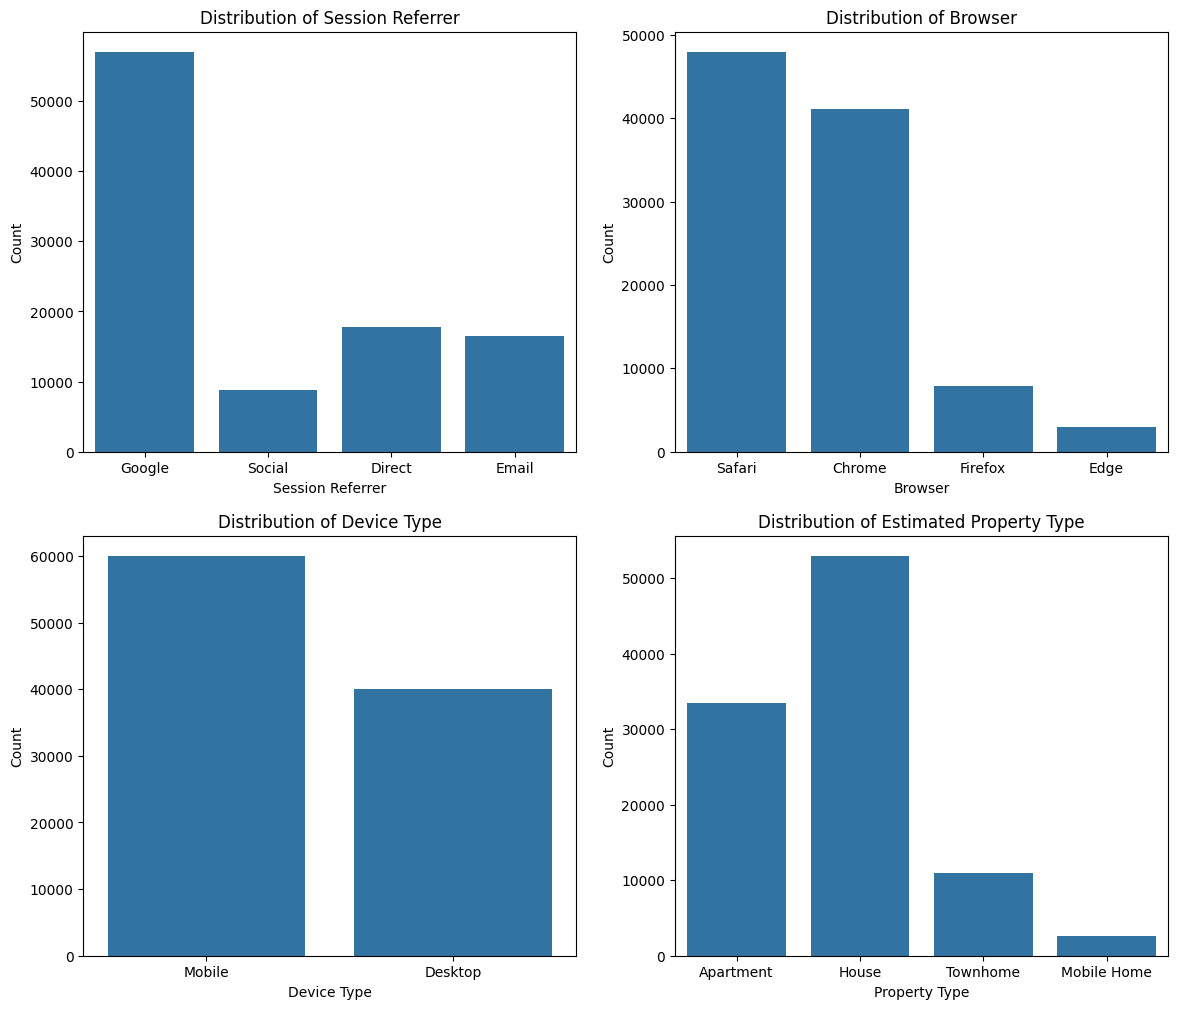

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(14, 12))
axs = axs.flatten()

#session referrer
sns.countplot(data=df, x='sessionReferrer', ax=axs[0])
axs[0].set_title('Distribution of Session Referrer')
axs[0].set_xlabel('Session Referrer')
axs[0].set_ylabel('Count')

#browser type
sns.countplot(data=df, x='browser', ax=axs[1])
axs[1].set_title('Distribution of Browser')
axs[1].set_xlabel('Browser')
axs[1].set_ylabel('Count')

#device type
sns.countplot(data=df, x='deviceType', ax=axs[2])
axs[2].set_title('Distribution of Device Type')
axs[2].set_xlabel('Device Type')
axs[2].set_ylabel('Count')

#property type
sns.countplot(data=df, x='estimatedPropertyType', ax=axs[3])
axs[3].set_title('Distribution of Estimated Property Type')
axs[3].set_xlabel('Property Type')
axs[3].set_ylabel('Count')

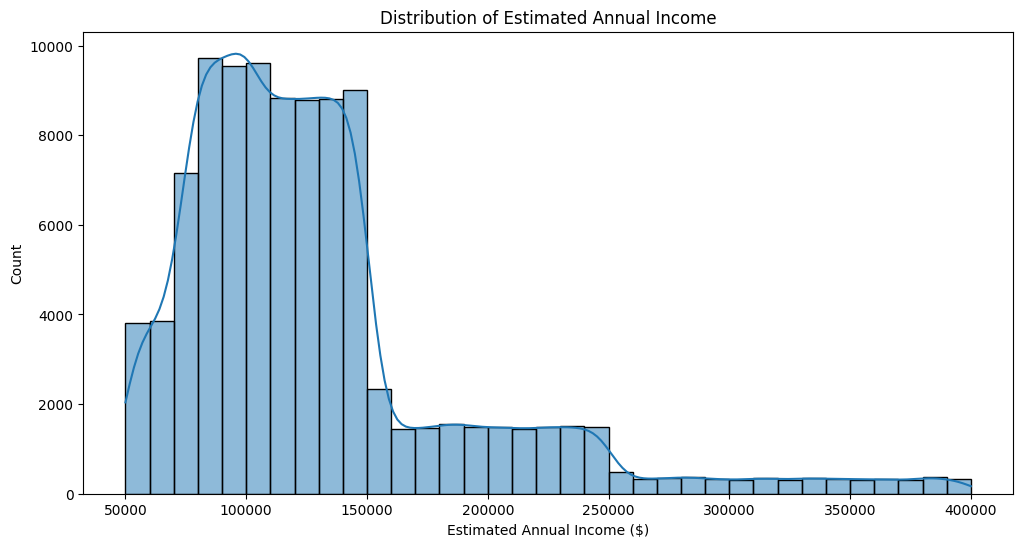

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=df, x='estimatedAnnualIncome', kde=True, ax=ax, binwidth=10000)
ax.set_title('Distribution of Estimated Annual Income')
ax.set_xlabel('Estimated Annual Income ($)')
ax.set_ylabel('Count');

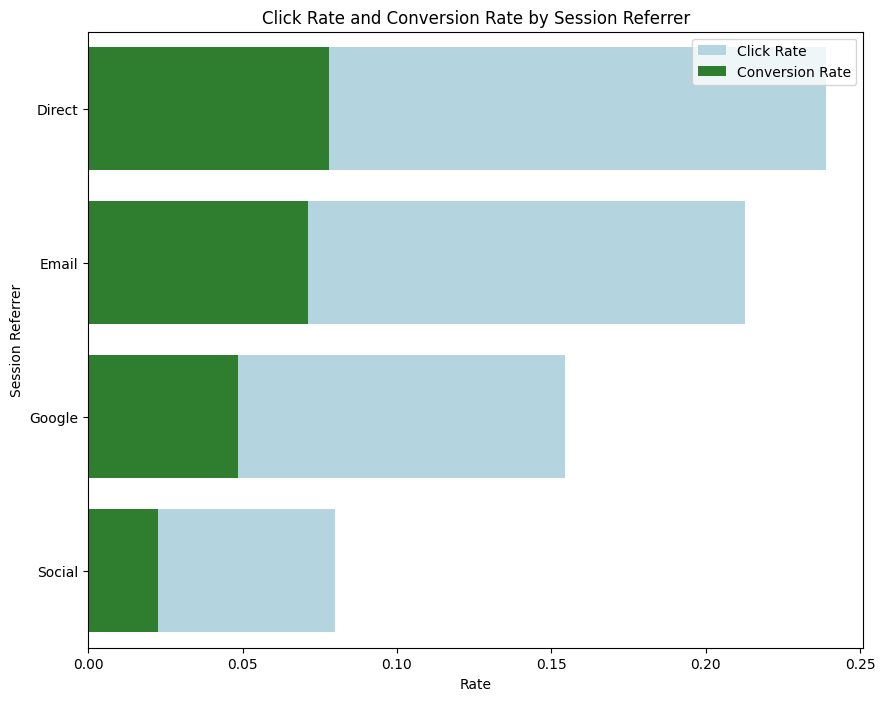

In [18]:
#Segment by session referrer
session_metrics = (
    df.groupby('sessionReferrer')
    .agg(clicks=('clickedCTA', 'sum'),
         impressions=('clickedCTA', 'count'),
         appointments=('scheduledAppointment', 'sum'))
    .reset_index()
)

session_metrics['clickRate'] = (session_metrics['clicks'] / session_metrics['impressions'])
session_metrics['conversionRate'] = (session_metrics['appointments'] / session_metrics['impressions'])

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=session_metrics, y='sessionReferrer', x='clickRate', color='lightblue', label='Click Rate')
sns.barplot(data=session_metrics, y='sessionReferrer', x='conversionRate', color='forestgreen', label='Conversion Rate')
ax.set_title('Click Rate and Conversion Rate by Session Referrer')
ax.set_xlabel('Rate')
ax.set_ylabel('Session Referrer')
ax.legend(loc='upper right');

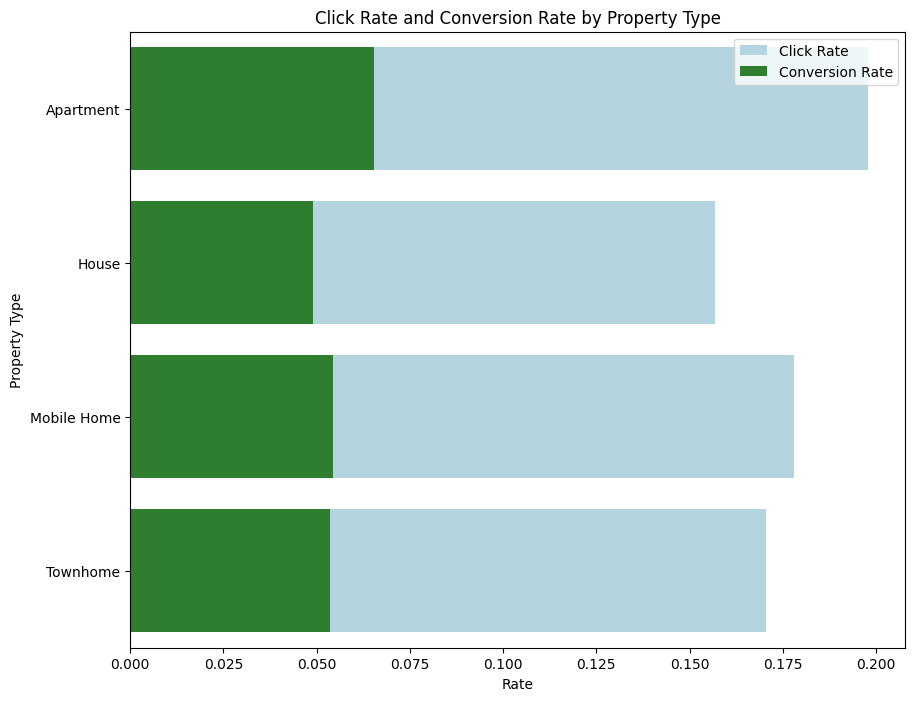

In [19]:
#Segment by property type
property_metrics = (
    df.groupby('estimatedPropertyType')
    .agg(clicks=('clickedCTA', 'sum'),
         impressions=('clickedCTA', 'count'),
         appointments=('scheduledAppointment', 'sum'))
    .reset_index()
)

property_metrics['clickRate'] = (property_metrics['clicks'] / property_metrics['impressions'])
property_metrics['conversionRate'] = (property_metrics['appointments'] / property_metrics['impressions'])

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=property_metrics, y='estimatedPropertyType', x='clickRate', color='lightblue', label='Click Rate')
sns.barplot(data=property_metrics, y='estimatedPropertyType', x='conversionRate', color='forestgreen', label='Conversion Rate')
ax.set_title('Click Rate and Conversion Rate by Property Type')
ax.set_xlabel('Rate')
ax.set_ylabel('Property Type')
ax.legend(loc='upper right');

Let's compute a correlation matrix between the site user features (sessionReferrer, browser, deviceType, estimatedAnnualIncome, estimatedPropertyType, visitCount) and our key metrics (clickRate, conversionRate, totalRevenue).

To do so, we must dummy encode our categorical features.

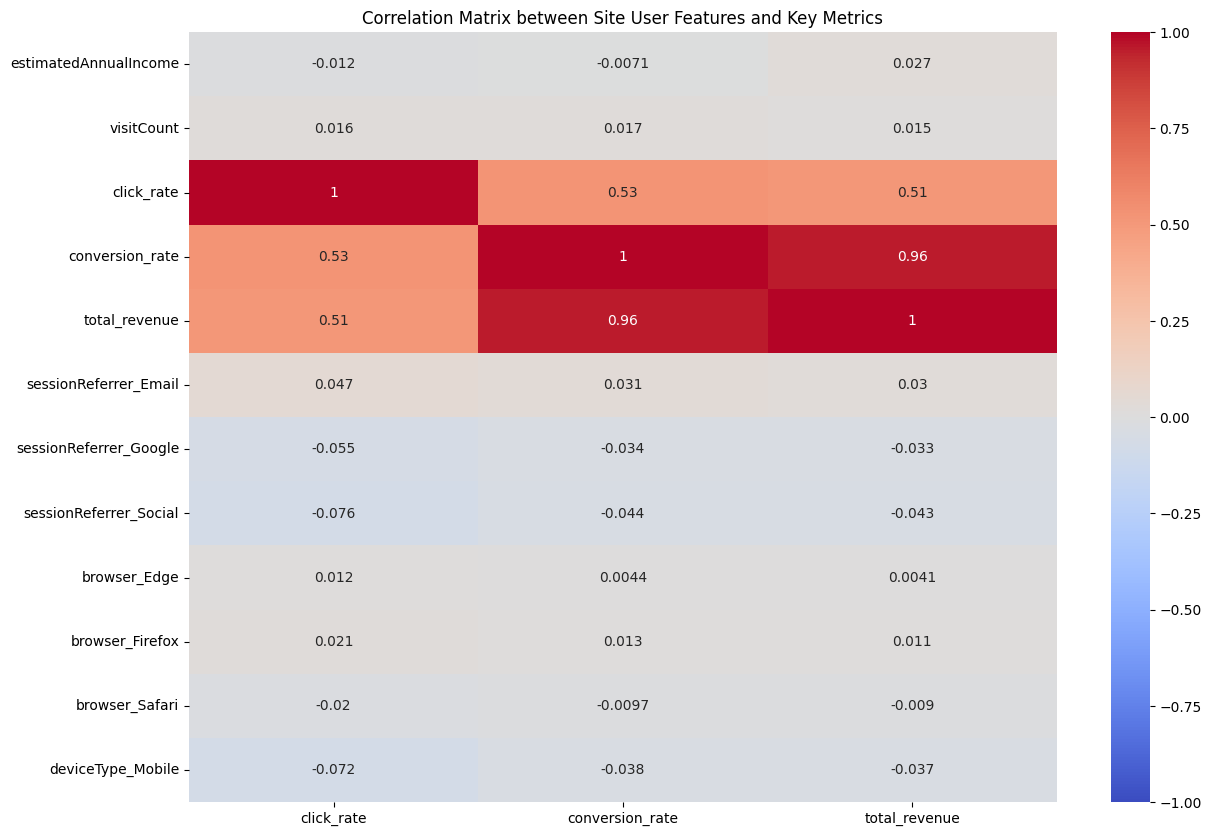

In [30]:
user_metrics = df.groupby('userId').agg(
    click_rate=('clickedCTA', lambda x: x.sum() / x.count() * 100),
    conversion_rate=('scheduledAppointment', lambda x: x.sum() / x.count() * 100),
    total_revenue=('revenue', 'sum')
).reset_index()

user_data = df[['userId', 'sessionReferrer', 'browser',
                'deviceType', 'estimatedAnnualIncome',
                'estimatedPropertyType', 'visitCount']].drop_duplicates()

merged_data = pd.merge(user_data, user_metrics, on='userId')
encoded_merged_data = pd.get_dummies(merged_data, columns=['sessionReferrer', 'browser', 'deviceType', 'estimatedPropertyType'], drop_first=True)
numerical_features = encoded_merged_data.select_dtypes(include=['number']).columns
correlation_matrix_site_metrics = (encoded_merged_data
                                   .drop(columns=['userId'])
                                   .corr()[['click_rate', 'conversion_rate', 'total_revenue']]
                                   .iloc[:-3])

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix_site_metrics, annot=True, cmap='coolwarm', vmin=-1, vmax=1)




It appears that no site user attributes have a strong correlation with any of our key metrics.

In [34]:
cta_user_metrics = df.groupby(['ctaCopy', 'ctaPlacement', 'deviceType', 'sessionReferrer', 'estimatedPropertyType']).agg(
    clicks=('clickedCTA', 'sum'),
    impressions=('clickedCTA', 'count'),
    appointments=('scheduledAppointment', 'sum'),
    total_revenue=('revenue', 'sum')
).reset_index()

cta_user_metrics['CTR'] = (cta_user_metrics['clicks'] / cta_user_metrics['impressions']) * 100
cta_user_metrics['conversion_rate'] = (cta_user_metrics['appointments'] / cta_user_metrics['impressions']) * 100

high_engagement_groups = (cta_user_metrics
                          .sort_values(by=['CTR', 'conversion_rate', 'total_revenue'],
                                       ascending=False)
)

high_engagement_groups[['ctaCopy', 'ctaPlacement',
                        'deviceType', 'sessionReferrer',
                        'estimatedPropertyType', 'CTR',
                        'conversion_rate', 'total_revenue']].head()


,ctaCopy,ctaPlacement,deviceType,sessionReferrer,estimatedPropertyType,CTR,conversion_rate,total_revenue
258,Get Pre-Approved for a Mortgage in 5 Minutes,Top,Desktop,Direct,Mobile Home,50.000000,22.727273,885
230,Get Pre-Approved for a Mortgage in 5 Minutes,Middle,Desktop,Email,Mobile Home,50.000000,18.181818,660
160,First Time? We've Made it Easy to Find the Bes...,Top,Desktop,Direct,Apartment,44.444444,13.580247,7275
210,Get Pre-Approved for a Mortgage in 5 Minutes,Bottom,Mobile,Direct,Mobile Home,43.750000,25.000000,660
128,First Time? We've Made it Easy to Find the Bes...,Middle,Desktop,Direct,Apartment,42.857143,15.057915,8535


As of right now, the editorial snippet and page url features are useless to nearly any ML algorithm we could use. I will attempt to categorize the URL links using my own simple reasoning to help extract information from the column. I would normally approach this using some form of NLP technique such as LDA, however I feel that may be a bit overkill for the time I have and the scope of this study.

Transforming columns by one-hot or dummy encoding is another approach that will help extract information from categorical columns that would otherwise be unused by many algorithms.

In [35]:
def categorize_url(url):
    if "types-of-mortgages" in url or "first-time-homebuyer-guide" in url or "what-is-mortgage" in url:
        return "Mortgage Basics and Education"
    elif "best-mortgage-rate" in url or "refinance-rates" in url or "30-year-mortgage-rates" in url or "mortgage-calculator" in url:
        return "Rates and Calculations"
    elif "best-mortgage-lenders" in url or "reviews" in url or "apply" in url:
        return "Lender and Application Process"
    else:
        return "Other"

df['urlCategory'] = df['pageURL'].apply(categorize_url)

## **Part C: Model Creation**

I decided to use a tree-based model for this problem. Specifically, I chose a random forest because of its interpretability and ability to handle mixed features. Additionally, these models tend to do better about generalizing to the data, safeguarding from overfitting. I decided against using a boosting model (such as XGBoost) because of its greater complexity and computational intensivity.

In order to recommend the copy and on-page placement for each individual user, I had to expand the dataset by creating entries for each possible ctaCombination per user. This allowed me to then evaluate all possible options for each user, ensuring that the model selected the most revenue-generating option.

In [37]:
df_expanded = pd.DataFrame()
df['ctaCombination'] = df['ctaCopy'] + " - " + df['ctaPlacement']
for combination in df['ctaCombination'].unique():
    temp = df.copy()
    temp['ctaCombination'] = combination
    df_expanded = pd.concat([df_expanded, temp], ignore_index=True)

categorical_features = ['deviceType', 'sessionReferrer', 'urlCategory', 'ctaCombination']
numerical_features = ['estimatedAnnualIncome', 'visitCount']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features),
        ('num', 'passthrough', numerical_features)
    ]
)

X = df_expanded[categorical_features + numerical_features + ['userId']]
#add error term to prevent division by 0
y = df_expanded['revenue'] / (df_expanded['clickedCTA'] + 1e-5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train = X_train.drop(columns=['userId'])
X_test = X_test.drop(columns=['userId'])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

model_pipeline.fit(X_train, y_train)

#get predicted revenue per click for each user & CTA combination
X_test_users = df_expanded[df_expanded['userId'].isin(X_test['userId'].unique())]
X_test_users = X_test_users.copy()
X_test_users['predicted_revenue'] = model_pipeline.predict(X_test_users[categorical_features + numerical_features])

#compute expected revenue per click by obtaining the optimal combo for each user
optimal_cta_per_user = X_test_users.loc[X_test_users.groupby('userId')['predicted_revenue'].idxmax()]


Expected Revenue per Click: 18.05024335737934


In [38]:
optimal_cta_per_user

,userId,sessionReferrer,browser,deviceType,estimatedAnnualIncome,estimatedPropertyType,visitCount,pageURL,ctaCopy,ctaPlacement,editorialSnippet,scrolledPage,scrollDepth,clickedCTA,scheduledAppointment,revenue,mortgageVariation,urlCategory,ctaCombination,predicted_revenue
46371,user_1,Social,Safari,Mobile,85000,House,1,https://www.financialservices.com/mortgages/be...,Get Pre-Approved for a Mortgage in 5 Minutes,Middle,"Compare rates, customer service, and loan opti...",1,75,0,0,0,NaN,Lender and Application Process,First Time? We've Made it Easy to Find the Bes...,0.000000
325682,user_10,Google,Chrome,Mobile,87000,House,1,https://www.financialservices.com/mortgages/ho...,First Time? We've Made it Easy to Find the Bes...,Bottom,Equip yourself with knowledge. Understand the ...,1,50,0,0,0,NaN,Rates and Calculations,Access Your Personalized Mortgage Rates Now - Top,18.069014
315701,user_100,Google,Safari,Desktop,144000,House,1,https://www.financialservices.com/mortgages/mo...,Access Your Personalized Mortgage Rates Now,Middle,Explore how different interest rates and loan ...,1,75,0,0,0,NaN,Rates and Calculations,Access Your Personalized Mortgage Rates Now - Top,30.924684
503534,user_1000,Google,Safari,Mobile,111000,House,1,https://www.financialservices.com/mortgages/fi...,Get Pre-Approved for a Mortgage in 5 Minutes,Top,Embarking on your first home purchase? Our com...,1,75,0,0,0,NaN,Mortgage Basics and Education,Get Pre-Approved for a Mortgage in 5 Minutes -...,12.603921
99352,user_10000,Google,Safari,Mobile,154000,Townhome,1,https://www.financialservices.com/mortgages/re...,Access Your Personalized Mortgage Rates Now,Bottom,Unlock new financial opportunities by refinanc...,1,25,0,0,0,NaN,Rates and Calculations,First Time? We've Made it Easy to Find the Bes...,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69237,user_99994,Email,Chrome,Desktop,144000,House,2,https://www.financialservices.com/mortgages/wh...,Get Pre-Approved for a Mortgage in 5 Minutes,Middle,We break down mortgage terminology and concept...,1,75,1,0,0,NaN,Mortgage Basics and Education,First Time? We've Made it Easy to Find the Bes...,0.000000
500934,user_99995,Direct,Safari,Mobile,142000,House,2,https://www.financialservices.com/mortgages/be...,First Time? We've Made it Easy to Find the Bes...,Bottom,Your choice of lender matters. Use our insight...,1,50,0,0,0,NaN,Lender and Application Process,Get Pre-Approved for a Mortgage in 5 Minutes -...,1.649984
357451,user_99996,Google,Chrome,Desktop,95000,Apartment,1,https://www.financialservices.com/mortgages/fi...,Access Your Personalized Mortgage Rates Now,Bottom,Navigate the home buying journey with confiden...,1,75,0,0,0,NaN,Mortgage Basics and Education,Access Your Personalized Mortgage Rates Now - Top,19.152361
69877,user_99998,Direct,Safari,Mobile,54000,Apartment,1,https://www.financialservices.com/mortgages/re...,First Time? We've Made it Easy to Find the Bes...,Bottom,Discover what sets top mortgage lenders apart....,0,0,0,0,0,NaN,Lender and Application Process,First Time? We've Made it Easy to Find the Bes...,0.000000


In [42]:
#evaluation
y_test_pred = model_pipeline.predict(X_test)
rmse = mean_squared_error(y_test, y_test_pred)**0.5
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 50.94583561587602


In [39]:
expected_revenue_per_click = optimal_cta_per_user['predicted_revenue'].mean()
print(f"Expected Revenue per Click: {expected_revenue_per_click}")

Expected Revenue per Click: 18.05024335737934


**Engagement Impact**

By selecting CTA combinations tailored to each user’s profile, the model is providing guidance on how to increase the likelihood of user engagement. The more engaged and tailored the CTA is for each user, means the higher conversion rate and thus generated revenue we will realize.

**Business Impact**

The increase from 12.79 to 18.05 in expected revenue per click represents an increase of approximately 41%. This substantial improvement directly impacts the bottom line, as it suggests that for every click, the we can now expect higher average revenue.

Additionally, this model enables a more targeted approach to CTA placement and content, helping better align each user's experience with their specific characteristics. This personalized strategy can help differentiate the business from competitors by offering a more user-centric experience.

